In [108]:
import numpy as np
import tensorflow as tf
import flowpm
import tensorflow_probability as tfp

In [109]:
cosmo={"w0":-1.0,
       "wa":0.0,
       "H0":100,
       "h":0.6774,
       "Omega0_b":0.04860,
       "Omega0_c":0.2589,
       "Omega0_m":0.3075,
       "Omega0_k":0.0,
       "Omega0_de":0.6925,
       "n_s":0.9667,
       "sigma8":0.8159}

# Planck 2015 paper XII Table 4 final column (best fit)

In [110]:
def fde(cosmo,a,epsilon=1e-5):
    a=tf.convert_to_tensor(a,dtype=tf.float32)
    w0=tf.convert_to_tensor(cosmo["w0"],dtype=tf.float32)
    wa=tf.convert_to_tensor(cosmo["wa"],dtype=tf.float32)
    return (-3.0*(1.0+w0)+
            3.0*wa*((a-1.0)/tf.math.log(a-epsilon)-1.0))

In [111]:
def w(cosmo,a):
    a=tf.convert_to_tensor(a,dtype=tf.float32)
    w0=tf.convert_to_tensor(cosmo["w0"],dtype=tf.float32)
    wa=tf.convert_to_tensor(cosmo["wa"],dtype=tf.float32)
    return w0+wa*(1.0-a)

In [112]:
def E(cosmo,a):
    a=tf.convert_to_tensor(a,dtype=tf.float32)
    return(tf.math.sqrt(
        cosmo["Omega0_m"]/tf.pow(a, 3)
        +cosmo["Omega0_k"]/tf.pow(a, 2)
        +cosmo["Omega0_de"]*tf.pow(a, fde(cosmo,a))))

In [113]:
def H(cosmo, a):
    a=tf.convert_to_tensor(a,dtype=tf.float32)
    return cosmo["H0"]*cosmo["h"] *(E(cosmo, a))

In [114]:
def dfde(cosmo,a,epsilon=1e-5):
    a=tf.convert_to_tensor(a,dtype=tf.float32)
    wa=tf.convert_to_tensor(cosmo["wa"],dtype=tf.float32)
    return (3*wa*
            (tf.math.log(a-epsilon)-(a-1)/(a-epsilon))
            /tf.math.pow(tf.math.log(a-epsilon),2))

In [115]:
def dEa(cosmo,a,epsilon=1e-5):
    a=tf.convert_to_tensor(a,dtype=tf.float32)
    return 0.5*(-3*cosmo["Omega0_m"]/tf.pow(a, 4)-2*cosmo["Omega0_k"]/tf.pow(a, 3)
    +dfde(cosmo,a)*cosmo["Omega0_de"]*tf.pow(a, fde(cosmo,a)))
    


In [116]:
def Omega_m_a(cosmo,a):
    a=tf.convert_to_tensor(a,dtype=tf.float32)
    return cosmo["Omega0_m"]*tf.math.pow(a,-3)/E(cosmo,a)**2

In [117]:
log10_amin=-3
steps=128
atab = np.logspace(log10_amin, 0.0, steps)
atab=tf.convert_to_tensor(atab,dtype=tf.float32)
y0 = 1
y0 = tf.convert_to_tensor(y0,dtype=tf.float32)

In [118]:
@tf.function
def growt_rate(y,a):
    a=tf.convert_to_tensor(a,dtype=tf.float32)
    dyda=tf.pow(y,2)*a+(2*a-(dEa(cosmo,a)/E(cosmo,a)))*y-1.5*Omega_m_a(cosmo,a)*a
    return dyda

In [119]:
@tf.function
def odesolve_rate(atab,y0):
    solver=tfp.math.ode.BDF()
    results = solver.solve(growt,atab[0], y0, solution_times=atab)
    return results


In [120]:
results_rate=odesolve_rate(atab,y0)

Populating the interactive namespace from numpy and matplotlib


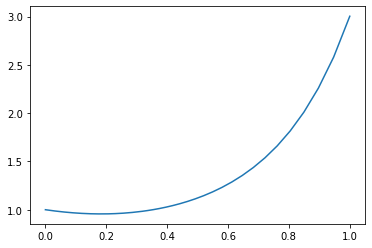

In [121]:
%pylab inline
plot(results.times,results.states)

In [122]:
y0 = np.array([atab[0], 1.0])
y0 = tf.convert_to_tensor(y0,dtype=tf.float32)

In [123]:
@tf.function
def growt_func(y,a):
    y=tf.convert_to_tensor(y)
    a=tf.convert_to_tensor(a)
    d,d_f=y
    dydt=[d_f,
         -d_f/a+
          tf.math.pow(d_f,2)/d+
          tf.math.pow(d_f,2)*tf.math.pow(a,2)/d+
          (2*a-(dEa(cosmo,a)/E(cosmo,a)))*d_f-
          1.5*Omega_m_a(cosmo,a)*d
         ]

In [124]:
@tf.function
def odesolve_func(atab,y0):
    solver=tfp.math.ode.BDF()
    results = solver.solve(growt,atab[0], y0, solution_times=atab)
    return results

In [125]:
results_func=odesolve_func(atab,y0)

Populating the interactive namespace from numpy and matplotlib


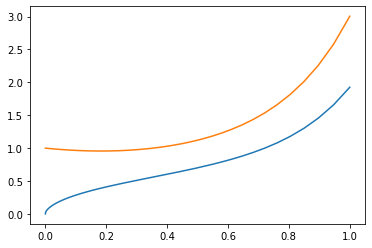

In [141]:
%pylab inline
plot(results_func.times,results_func.states)
savefig("growt_function.png",dpi=200)